In [ ]:
'''
회귀분석
'''

In [1]:
import pandas as pd

from sklearn.datasets import load_diabetes
raw = load_diabetes()

raw_df = pd.DataFrame(raw['data'], columns=raw['feature_names'])
raw_df['target'] = raw['target']
raw_df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [2]:
df = raw_df.copy()
target_col = 'target'

In [3]:
X = df.drop(columns=[target_col])
y = df[target_col]

In [4]:
import statsmodels.api as sm

X_const = sm.add_constant(X)
model = sm.OLS(y, X_const)
model_fitted = model.fit()
print(model_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.27
Date:                Thu, 24 Apr 2025   Prob (F-statistic):           3.83e-62
Time:                        15:50:56   Log-Likelihood:                -2386.0
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     431   BIC:                             4839.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.576     59.061      0.0

In [5]:
# 변수선택의 필요성 1
model_p_vals = model_fitted.pvalues
model_p_vals[model_p_vals > 0.1]

age    0.867031
s2     0.160390
s3     0.634723
s4     0.273459
s6     0.305990
dtype: float64

In [6]:
# 변수선택의 필요성 2
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

feature_vif_dict = dict()
for idx, col in enumerate(X_const.columns):
    vif = VIF(X_const, idx)
    feature_vif_dict[col] = vif
vif_df = pd.DataFrame([feature_vif_dict],index=['VIF']).T
vif_df = vif_df.reset_index(names='feature')

vif_df[vif_df['VIF'] > 10]

,feature,VIF
5,s1,59.202510
6,s2,39.193370
7,s3,15.402156
9,s5,10.075967


In [7]:
# 변수 선택 지표
def get_aic(model):
    return model.aic

def get_bic(model):
    return model.bic

def get_adj_r2(model):
    return model.rsquared_adj

In [8]:
# 전진 선택법

def forward_selection_lb(X, y, scorer):
    ''' lower better '''
    features = []
    columns = X.columns.to_list()

    current_score = float('inf')

    while columns:
        score_feature_list = []
        for col in columns:
            _features = features + [col]
            X_const = sm.add_constant(X[_features])
            model = sm.OLS(y, X_const).fit()
            score = scorer(model)
            score_feature_list.append((score, col))

        best_score, best_feature = min(score_feature_list, key=lambda x: x[0])

        if best_score < current_score:
            print(f'score {current_score:.2f} => {best_score:.2f}')
            print(f'feature : {best_feature}')
            current_score = best_score
            features.append(best_feature)
            columns.remove(best_feature)

        else:
            break
        
    return features

def forward_selection_ub(X, y, scorer):
    ''' upper better '''
    features = []
    columns = X.columns.to_list()

    current_score = float('-inf')

    while columns:
        score_feature_list = []
        for col in columns:
            _features = features + [col]
            X_const = sm.add_constant(X[_features])
            model = sm.OLS(y, X_const).fit()
            score = scorer(model)
            score_feature_list.append((score, col))
        
        best_score, best_feature = max(score_feature_list, key=lambda x: x[0])

        if current_score < best_score:
            print(f'score {current_score:.2f} => {best_score:.2f}')
            print(f'feature : {best_feature}')
            current_score = best_score
            features.append(best_feature)
            columns.remove(best_feature)

        else:
            break

    return features

In [9]:
# 후진 제거법

def backward_elimination_lb(X, y, scorer):
    features = X.columns.to_list()
    current_score = float('inf')
    while len(features):
        score_feature_list = []
        
        for col in features:
            _features = [feature for feature in features if feature != col]
            X_const = sm.add_constant(X[_features])
            model = sm.OLS(y, X_const).fit()
            score = scorer(model)
            score_feature_list.append((score, col))
        
        best_score, worst_feature = min(score_feature_list, key=lambda x: x[0])

        if best_score < current_score:
            print(f'score {current_score:.2f} => {best_score:.2f}')
            print(f'feature : {worst_feature}')
            current_score = best_score
            features.remove(worst_feature)
        
        else:
            break

    return features

def backward_elimination_ub(X, y, scorer):
    features = X.columns.to_list()
    current_score = float('-inf')
    while len(features):
        score_feature_list = []

        for col in features:
            _features = [feature for feature in features if feature != col]
            X_const = sm.add_constant(X[_features])
            model = sm.OLS(y, X_const).fit()
            score = scorer(model)
            score_feature_list.append((score, col))

        best_score, worst_feature = max(score_feature_list, key=lambda x: x[0])

        if current_score < best_score:
            print(f'score {current_score:.2f} => {best_score:.2f}')
            print(f'feature : {worst_feature}')
            current_score = best_score
            features.remove(worst_feature)

        else:
            break

    return features

In [10]:
# 단계적 선택법

def stepwise_selection_lb(X, y, scorer):
    features = []
    columns = list(X.columns)

    current_score = float('inf')
    changed = True

    while changed:
        changed = False
        # Forward Step
        remaining_features = list(set(columns) - set(features))
        forward_scores = []

        for column in remaining_features:
            try_features = features + [column]
            X_const = sm.add_constant(X[try_features])
            model = sm.OLS(y, X_const).fit()
            score = scorer(model)
            forward_scores.append((score, column))

        if forward_scores:
            best_score, best_feature = min(forward_scores, key=lambda x: x[0])

            if best_score < current_score:
                features.append(best_feature)
                current_score = best_score
                changed = True
                print(f"추가된 변수: {best_feature}, score: {best_score:.4f}")

        # Backward Step
        if len(features) > 1:
            backward_scores = []

            for column in features:
                try_features = [f for f in features if f != column]
                X_const = sm.add_constant(X[try_features])
                model = sm.OLS(y, X_const).fit()
                score = scorer(model)
                backward_scores.append((score, column))

            worst_score, worst_feature = min(backward_scores, key=lambda x: x[0])

            if worst_score < current_score:
                features.remove(worst_feature)
                current_score = worst_score
                changed = True
                print(f" 제거된 변수: {worst_feature}, score: {worst_score:.4f}")

    return features

def stepwise_selection_ub(X, y, scorer):
    features = []
    columns = list(X.columns)

    current_score = float('-inf')
    changed = True

    while changed:
        changed = False
        # Forward Step
        remaining_features = list(set(columns) - set(features))
        forward_scores = []

        for column in remaining_features:
            try_features = features + [column]
            X_const = sm.add_constant(X[try_features])
            model = sm.OLS(y, X_const).fit()
            score = scorer(model)
            forward_scores.append((score, column))

        if forward_scores:
            best_score, best_feature = max(forward_scores, key=lambda x: x[0])

            if current_score < best_score:
                features.append(best_feature)
                current_score = best_score
                changed = True
                print(f"추가된 변수: {best_feature}, score: {best_score:.4f}")

        # Backward Step
        if len(features) > 1:
            backward_scores = []

            for column in features:
                try_features = [f for f in features if f != column]
                X_const = sm.add_constant(X[try_features])
                model = sm.OLS(y, X_const).fit()
                score = scorer(model)
                backward_scores.append((score, column))

            worst_score, worst_feature = max(backward_scores, key=lambda x: x[0])

            if current_score < worst_score:
                features.remove(worst_feature)
                current_score = worst_score
                changed = True
                print(f" 제거된 변수: {worst_feature}, score: {worst_score:.4f}")

    return features

In [12]:
using_features = forward_selection_lb(X, y, get_aic)
X = X.loc[:, using_features]
X_const = sm.add_constant(X)

score inf => 4912.04
feature : bmi
score 4912.04 => 4828.40
feature : s5
score 4828.40 => 4813.23
feature : bp
score 4813.23 => 4804.96
feature : s1
score 4804.96 => 4800.08
feature : sex
score 4800.08 => 4788.60
feature : s2


In [13]:
model = sm.OLS(y, X_const)
model_fitted = model.fit()

In [14]:
model_predicted = model_fitted.predict(X_const)

In [17]:
residual = y - model_predicted

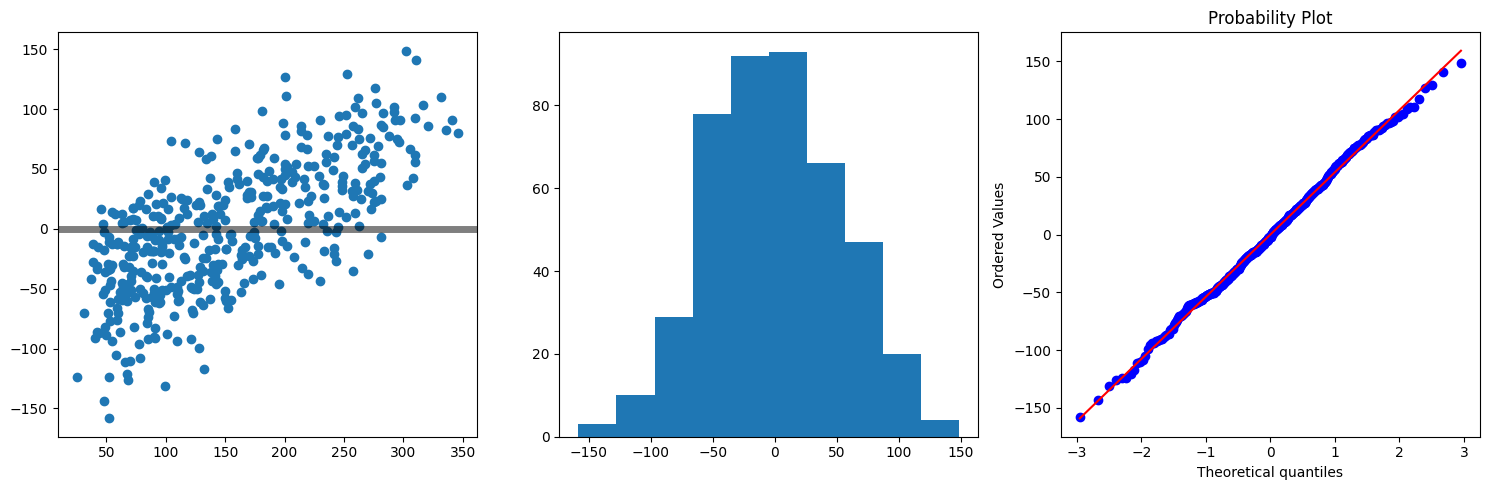

In [18]:
from scipy.stats import probplot
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. 잔차 그래프
ax = axes[0]
ax.scatter(y, residual)
ax.axhline(y=0, linewidth=5, color='k', alpha=0.5)

# 2. 잔차 histogram
ax = axes[1]
ax.hist(residual)

# 3. 잔차 q-qplot
ax = axes[2]
probplot(residual, plot=ax)

plt.tight_layout()
plt.show()